In [1]:
# Disclaimer: This tutorial is by no means meant to be complete in presenting the complex
# topic of Umbrella sampling (US) simulations and their analysis. It is meant to provide an
# introduction and some initial guidelines on how to perform such simulations and analyse them.

In [2]:
# All steps in the tutorial can be performed through the notebook interface here, or by
# running the individual python scripts that are located in the subfolders with the notebook.
# The scripts will by default just prepare the run input files with a small number of steps
# to run (so that it can be done on any machine), but can also be invoked with additional
# options to perform the acutal simulations that provided the data used in the final analysis.

In [3]:
# The tutorial is based on material available from both
# Justin Lemkul (http://www.bevanlab.biochem.vt.edu/Pages/Personal/justin/gmx-tutorials/umbrella/index.html)
# and Wes Barnett (https://wbarnett.us/tutorials/5_umbrella/)
# We will be simulating a system of two pyrimidine molecules in water
# and will try to estimate the Potential of Mean Force (PMF) for
# moving those two molecules together from infinite distance.

In [4]:
# The files for the pyrimidine topology are available from the
# http://virtualchemistry.org/ database on organic molecules.
# They can be downloaded here for GROMACS 
# http://virtualchemistry.org/molecule.php?filename=pyrimidine.zmat
# For the tutorial, the files have already been downloaded and prepared
# for running, but if you want to try you can prepare a different small
# molecule yourself!

In [5]:
# The tutorial files are all available through git if not already installed.
# To set up the tutorial contents, we will run git clone to obtain
# all the files and set up the directory structure

In [6]:
# Having set up the folder structure, you can go and explore it through
# the terminal and see what is in there. All the files to perform the
# simulation and run the analysis are present. We will be now performing
# the preparation of the simulations and run some short tests
# The following directories are present:
# 0-files    -> Containing all the unmodified files used for setting up the simulation
#               These include an empty topology with just water in a box, as well
#               as the topology files for pyrimidine
# 1-topology -> Containing inputs to generate the basic topology with 
#               two pyrimidine molecules by using gmx insert-molecules
#               and the folders for the steps to change the box size, solvation
#               and adding of ions 
# 2-umbrella -> Contains a set of scripts to run the actual simulations
#               for each window of the reaction coordinate. This is meant
#               to be used on a cluster instead, and running the jobs is not
#               part of this tutorial
# 3-analysis -> Folder with data from simulations performed previously that can
#               be analysed to obtain the PMF of the simulation

In [7]:
import os
import shutil
import subprocess
path = os.getcwd()
print path

/data/us-tutorial


In [8]:
# We start by importing all our helper functions
from functions import *
# followed by preparation of the actual simulations by checking that we have a GROMACS
# installation in our $PATH to make sure we can run the program
if not which('gmx'):
    print "%s not found in $PATH" % 'gmx'
# followed by setting the global path name
globalpath = os.getcwd()

In [9]:
# if the script tells you that gmx (the GROMACS wrapper binary)
# is not in the $PATH, close the notebook, source the used GROMACS
# installation and try again

In [10]:
######################################
# Step 1 - Preparing run input files #
######################################

In [11]:
os.chdir(globalpath+'/1-topology/insert')

In [12]:
# Prepare initial topology by inserting two molecules of pyrimidine
# into an empty box

In [13]:
commandlist = ["gmx","insert-molecules","-ci","pyrimidine_T298.15_gas.pdb","-box","3","3","3","-nmol","2","-o","pyrimidine_insert.gro"]
subprocess.check_call(commandlist)

0

In [14]:
# this will give us the new structure file with the two molecules randomly oriented
# we can copy this file to the next directory to change the size of the 
# simulation box so that we can later calculate the full PMF

In [15]:
structurefile = "pyrimidine_insert.gro"
nextdir = globalpath+"/1-topology/box"

shutil.copy2(structurefile,nextdir)
os.chdir(nextdir)

In [16]:
# in the next directory, we change the box to be 5 nm in each direction
commandlist = ["gmx", "editconf", "-f", "pyrimidine_insert.gro", "-o", "pyrimidine_largebox.gro", "-box", "5", "5", "5"]
subprocess.check_call(commandlist)

0

In [17]:
# we also prepared a topology file, topol.top, that can be used for the later steps
# in the same directory. It contains only the basic information for using two molecules
# of pyrimidine, as well as the location of the files needed to run the remaining steps
# we copy those files to the next directory to solvate the structure before the minimzation
# the file will be written with the information about its position, so it can properly include
# the correct forcefield that contains the information for pyrimidine

In [18]:
writetopfile("topol.top", globalpath)

In [19]:
copyfiles = ["pyrimidine_largebox.gro", "topol.top"]
nextdir = globalpath+"/1-topology/solvate"

for files in copyfiles:
    shutil.copy2(files,nextdir)
    
os.chdir(nextdir)

In [20]:
# the next step is basic solvation with gmx solvate

In [21]:
commandlist = ["gmx", "solvate", "-cp", "pyrimidine_largebox.gro", "-cs", "tip4p", "-p", "topol.top", "-o", "solv.gro"]
subprocess.check_call(commandlist)

0

In [22]:
# followed by copying the files again to the final directory, where we add ions to
# obtain a physical system
copyfiles = ["solv.gro", "topol.top"]
nextdir = globalpath+"/1-topology/ion"
for files in copyfiles:
    shutil.copy2(files,nextdir)
    
os.chdir(nextdir)

In [23]:
# in this directory you will find an example mdp input file that is used
# to generate the tpr file needed by gmx genion
# first, we run grompp on the structure to generate the tpr
commandlist = ["gmx", "grompp", "-f", "ions", "-c", "solv", "-p", "topol", "-o", "ions"]
subprocess.check_call(commandlist)

0

In [24]:
# next, we run gmx genion to actually add the ions to the structure
read, write = os.pipe()
os.write(write, "4")
os.close(write)

commandlist = ["gmx", "genion", "-s", "ions", "-nname", "CL", "-pname", "NA", "-neutral", "-conc", "0.15", "-o", "ions"]
subprocess.check_call(commandlist, stdin=read)

0

In [25]:
# this concludes the topology preparation
# next, we will copy the final files to the run directory and prepare the
# index file needed to run the simulation with the different pull groups
# the index file needs to be modified as shown during the lecture, to add the
# groups PYR1 and PYR2 for the two pyrimidine molecules
# after you have done this, continue to the next step

In [26]:
copyfiles = ["ions.gro", "topol.top", "index.ndx"]
nextdir = globalpath+"/2-umbrella"
for files in copyfiles:
    shutil.copy2(files,nextdir)
    
os.chdir(nextdir)

In [27]:
# In this directory, we will run the script that performs the simulation
# of the individual umbrella windows. As each of those simulations might take several hours,
# we will only prepare a set of example simulations and not actual run all of them.
# The python command used to prepare them can also be used to run them, but this should
# be done instead on a dedicated system with the necessary computing capabilities

In [28]:
inputdir = globalpath+"/2-umbrella"
umbrella(25,False,2.5,0.05,inputdir)

In [29]:
# If you have run this simulation, you can now try to analyse it, or proceed with the data that
# has already been prepared for you in another folder.
# Here, we go to this new folder and analyse the data files present there.
# If you did run the simulations, you will have to copy the result files there
nextdir = "../3-analysis"
os.chdir(nextdir)

In [30]:
# Here, we prepared data files and the setup to execute the gmx wham command on
# the simulation data. If you are unsure about what gmx wham does, please have a look
# at the manual pages (gmx wham -h). To obtain the free energy profile and the
# histograms from the US, we need to have a list of both the input files (*tpr) and
# pull coordinate (pullx*) or pull force (pullf*) files. This has already been done for
# you in the files tpr.dat, pullf.dat and pullx.dat.
# When running gmx wham on them, the program will analyse the data found within
# to build the histograms and final free energy profile. We will do this the
# most trivial way possible here.

In [31]:
commandlist = ["gmx", "wham", "-it", "tpr.dat", "-ix", "pullx.dat", "-o", "-hist"]
subprocess.check_call(commandlist)

0

In [32]:
# The program generated for us now the plot files in xvg format, that can be opened here
# for visualization. First, the free energy profile
import numpy as np
import matplotlib.pyplot as plt

x, y = [], []

with open("profile.xvg") as f:
    for line in f:
        cols = line.split()
        if not line.startswith('@') and not line.startswith('#'):

                x.append(float(cols[0]))
                y.append(float(cols[1]))


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title("Free energy profile")    
ax1.set_xlabel('Umbrella sampling window position (A)')
ax1.set_ylabel('Energy (kJ/mol)')
ax1.plot(x,y, c='r', label='Pyrimidine PMF')
leg = ax1.legend()
plt.show()

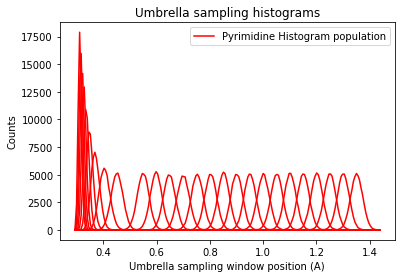

In [33]:
# Second plot for the histogram data
import numpy as np
import matplotlib.pyplot as plt

x, y = [], []

with open("histo.xvg") as f:
    for line in f:
        cols = line.split()
        if not line.startswith('@') and not line.startswith('#'):

            colnum = len(cols)
            x.append(float(cols[0]))
            tmpy = []
            for col in range (1, colnum-1):
                tmpy.append(float(cols[col]))
            y.append(tmpy)


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title("Umbrella sampling histograms")    
ax1.set_xlabel('Umbrella sampling window position (A)')
ax1.set_ylabel('Counts')
ax1.plot(x,y, c='r', label='Pyrimidine Histogram population')
leg = ax1.legend()
plt.show()